# Simplified pixel sim for interpolation tests


In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import time 
import h5py
import numpy as np
import aare
import boost_histogram as bh
import seaborn as sns
import pickle

#Debugging
import torch

from simple_eta import plot_gaussian, charge_and_pixel_plot
from simple_eta import generate, Generator


g = Generator.fromJSON('moench_g4_hg.json')
g.device = 'mps'
g.photon_energy = 8.0

## Generate one photon hit and plot response

t.shape=torch.Size([400, 400])
[0, 1, 2]


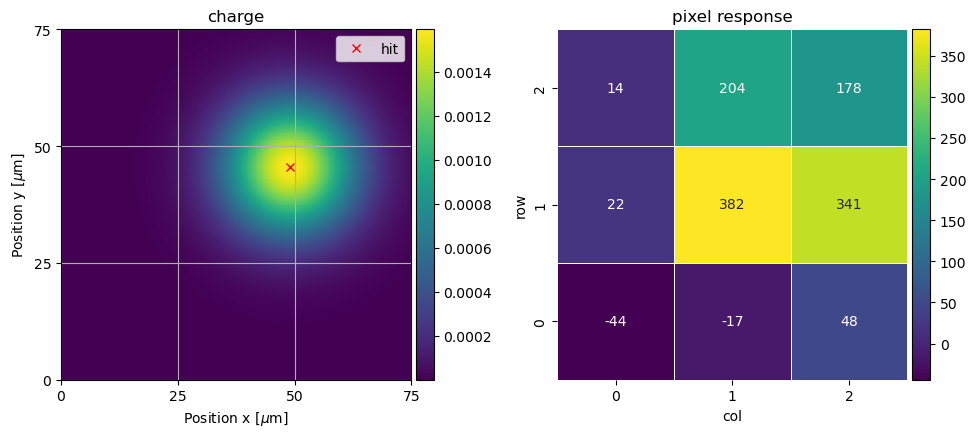

In [26]:
pos = (49.,45.5) #x,y
charge, pixels = g.hit(*pos)
fig, axs = charge_and_pixel_plot(charge, pixels, pos, g.pixel_size, g.grid_size)

## Generate hit positions

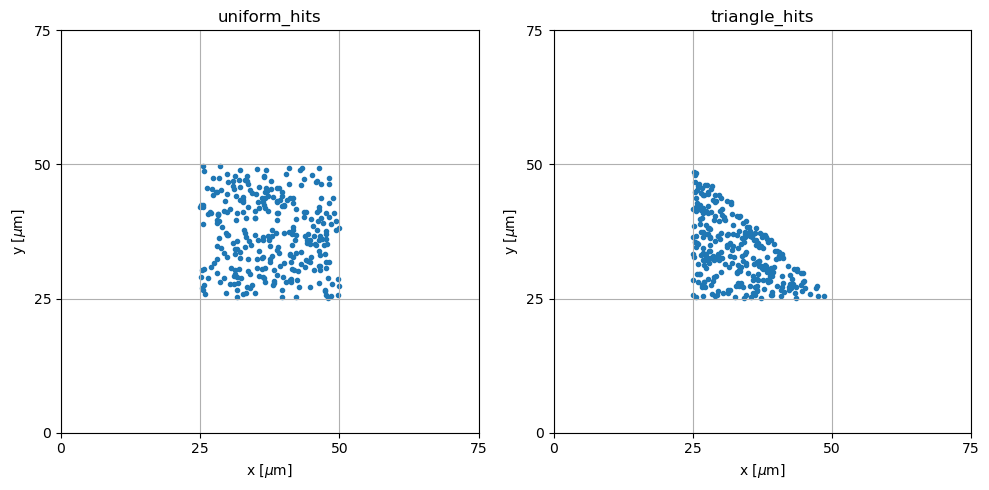

In [27]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
ticks = [tick for tick in np.arange(0,g.pixel_size*g.grid_size+1, g.pixel_size)]

for ax, func in zip(axs, [g.uniform_hits, g.triangle_hits]):
    mx, my, pixels = func(300)
    if g.device != 'cpu':
        mx = mx.cpu()
        my = my.cpu()
        
    ax.scatter(mx,my, marker = '.')
    ax.set_xlim(0,g.grid_size*g.pixel_size)
    ax.set_ylim(0,g.grid_size*g.pixel_size)
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(func.__name__)
    ax.set_xlabel(r'x [$\mu$m]')
    ax.set_ylabel(r'y [$\mu$m]')
    
    ax.grid()
fig.tight_layout()

## Generate hits for ETA and write to cluster file

In [4]:
generate_hits = False
n_hits = 1000
n_frames = 10000


tag = '_B'

if generate_hits:
    g.write_clusters_for_eta(n_hits, n_frames, tag = tag)


9999
Duration: 1228.624s, FPS: 8.14, hits/s: 8.1e+03s


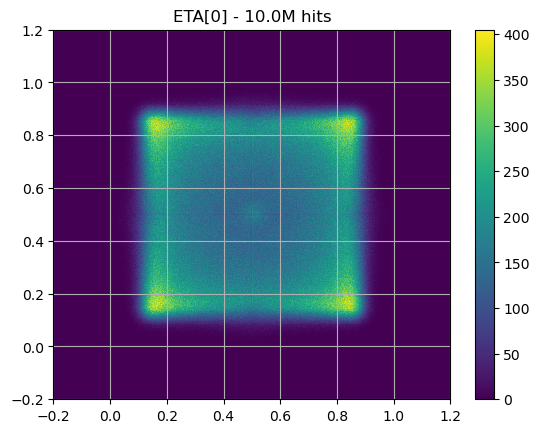

In [32]:
#configure the eta histogram
n_bins = 400
ax_min = -0.2
ax_max = 1.2
e_min = 0  
e_max = 50000000 #309000
e_bins = 1

#Histogram to hold the ETA value per energy bin
eta_hist = bh.Histogram(
    bh.axis.Regular(n_bins, ax_min, ax_max), 
    bh.axis.Regular(n_bins, ax_min, ax_max),
    bh.axis.Regular(e_bins, e_min, e_max),
)


with aare.ClusterFile(f'.data/test_{g.grid_size}x{g.grid_size}{tag}.clust', cluster_size = (g.grid_size,g.grid_size)) as f:
    for clusters in f:
        eta2 = aare.calculate_eta2(clusters)
        # eta2 = aare.calculate_eta3(clusters)
        eta_hist.fill(eta2['x'], eta2['y'], eta2['sum'])


#Save histogram
with open(f".data/test_{g.grid_size}x{g.grid_size}{tag}.pkl", "wb") as f:
    pickle.dump(eta_hist, f)

energy_index = 0
data = eta_hist.view()[:,:,energy_index]
x = eta_hist.axes.edges.T[0].flat
y = eta_hist.axes.edges.T[1].flat

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x,y,data)
fig.colorbar(mesh)
ax.set_title(f'ETA[{energy_index}] - {data.sum()/1e6}M hits')
ax.grid()

(15.0, 60.0)

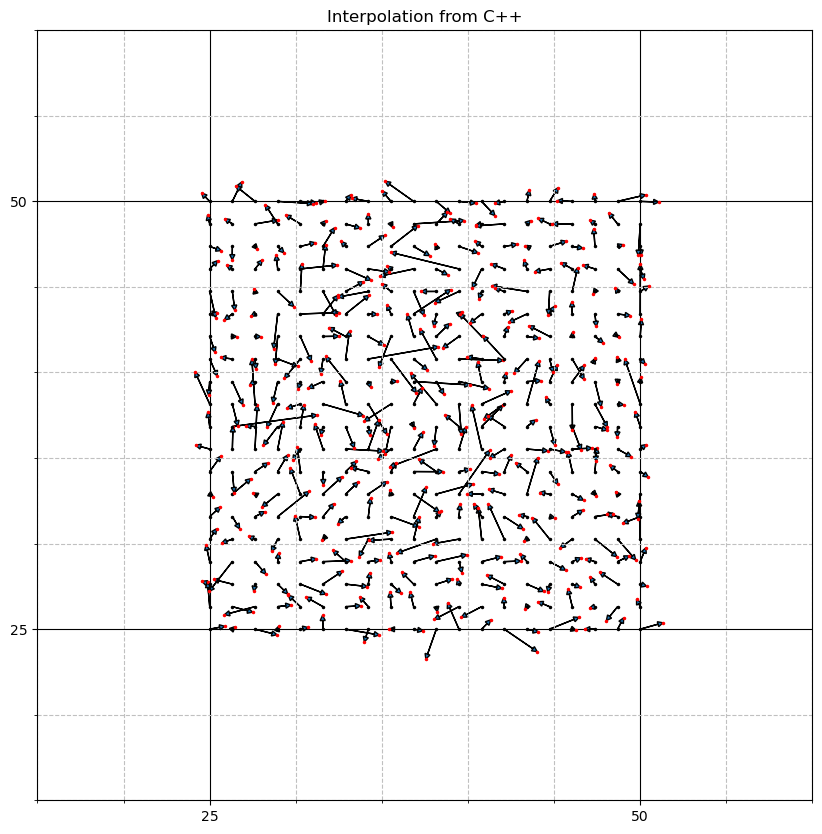

In [13]:
etabinsx = np.array(eta_hist.axes.edges.T[0].flat)
etabinsy = np.array(eta_hist.axes.edges.T[1].flat)
ebins = np.array(eta_hist.axes.edges.T[2].flat)
p = aare.Interpolator(eta_hist, etabinsx, etabinsy, ebins)
v = aare.ClusterVector((g.grid_size,g.grid_size))

show_arrows = True
a = np.linspace(25,50,20)
hit_position = np.zeros((a.size**2,2))
interpolated_position = np.zeros(hit_position.shape)
for i in range(a.size):
    for j in range(a.size):
        hit_position[i*a.size+j] = (a[i], a[j])

for i, hit in enumerate(hit_position):
    charge, pixels = g.hit(*hit)
    pixels = (pixels*1000).astype(np.int32)
    pixels = np.array(pixels).reshape(1,9)[0]
    c = aare._aare.Cluster3x3i(1,1,pixels)
    v.push_back(c)

tmp = p.interpolate(v)
# offset = 25/2
offset = 0
interpolated_position[:, 0] = tmp['x']*25+offset
interpolated_position[:, 1] = tmp['y']*25+offset


fig, ax = plt.subplots(figsize=(10,10))
for i in range(hit_position.shape[0]):
    ax.plot(*hit_position[i], '.', color = 'black', ms = 3)
    ax.plot(*interpolated_position[i], '.', color = 'red', ms = 3)
    if show_arrows:
        ax.arrow(*hit_position[i], *(interpolated_position[i]-hit_position[i]),length_includes_head=True,
              head_width=0.3, head_length=0.3)


ax.set_title('Interpolation from C++')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ticks = [tick for tick in np.arange(0,g.pixel_size*g.grid_size+1, g.pixel_size)]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.grid(visible=True, which='minor', color='silver', linestyle='--')
ax.grid(visible=True, which='major', color='black', linestyle='-')
ax.set_xlim(15,60)
ax.set_ylim(15,60)

## Interpolate one pixel from the ETA dataset

- Uniformity
- Correct assignment

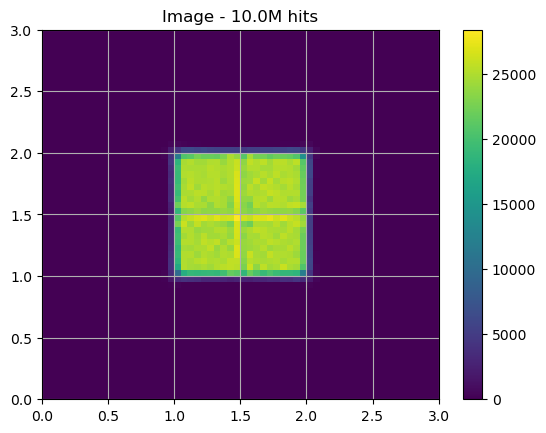

In [11]:
#Lets take the same eta dataset and interpolate
n_subpixels = 20
n_bins = g.grid_size*n_subpixels
image_hist = bh.Histogram(
    bh.axis.Regular(n_bins, 0, g.grid_size), 
    bh.axis.Regular(n_bins, 0, g.grid_size),
    # bh.axis.Regular(e_bins, e_min, e_max),
)


with aare.ClusterFile(f'.data/test_{g.grid_size}x{g.grid_size}{tag}.clust', cluster_size = (g.grid_size,g.grid_size)) as f:
    for clusters in f:
        # eta_hist.fill(eta2[:,0], eta2[:,1], energy['sum'])
        hits = p.interpolate(clusters)
        image_hist.fill(hits['x'], hits['y'])

image = image_hist.view()
x = image_hist.axes.edges.T[0].flat
y = image_hist.axes.edges.T[1].flat

fig, ax = plt.subplots()
mesh = ax.pcolormesh(x,y,image)
fig.colorbar(mesh)
ax.set_title(f'Image - {image.sum()/1e6}M hits')
ax.grid()

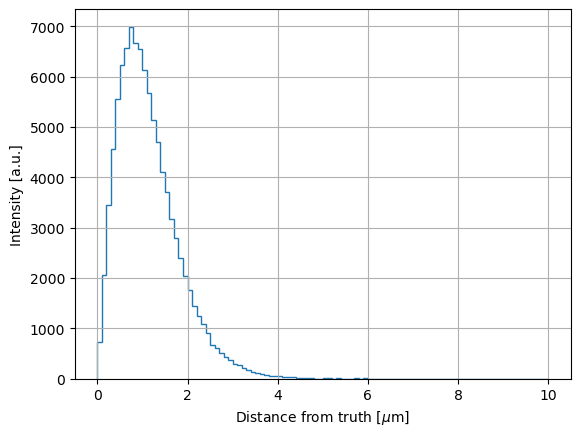

In [12]:
err_hist = bh.Histogram(
    bh.axis.Regular(100, 0, 10) #um
)
with aare.ClusterFile(f'.data/test_{g.grid_size}x{g.grid_size}{tag}.clust', cluster_size = (g.grid_size,g.grid_size)) as f:
    with h5py.File(f'.data/test_{g.grid_size}x{g.grid_size}{tag}.h5') as hf:
        
        for i in range(100):
            clusters = f.read_frame()
            x,y = hf['x'][i], hf['y'][i]
            # eta_hist.fill(eta2[:,0], eta2[:,1], energy['sum'])
            hits = p.interpolate(clusters)
            # image_hist.fill(hits['x'], hits['y'])
            error = np.sqrt(np.abs(hits['x']*g.pixel_size-x)**2+np.abs(hits['y']*g.pixel_size-y)**2)
            err_hist.fill(error)

fig, ax = plt.subplots()
ax.stairs(err_hist.values(), err_hist.axes[0].edges);
ax.set_xlabel(r'Distance from truth [$\mu$m]')
ax.set_ylabel('Intensity [a.u.]')
ax.grid()